In [11]:
import configparser
import os

import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib.patches import Polygon

import cv2
import imutils
import configparser

In [12]:
import configparser

config = configparser.ConfigParser()
config.read('secrets.ini')

# custom vision api
custom_vision_key = '31af6591881a47a1ad6117887e1bb6a2'
custom_vision_url = 'https://southcentralus.api.cognitive.microsoft.com/customvision/v3.0/Prediction/274eae9a-2e24-40db-8083-fd0e1394eef1/detect/iterations/License%20Plate%20Identification/url'
custom_vision_imgurl = 'https://southcentralus.api.cognitive.microsoft.com/customvision/v3.0/Prediction/274eae9a-2e24-40db-8083-fd0e1394eef1/detect/iterations/License%20Plate%20Identification/image'

# computer vision text recognition api
subscription_key = 'fde81e210a3247c182db3bf3870394e3'
endpoint = 'https://rampure.cognitiveservices.azure.com/'
text_recognition_url = endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"

In [13]:
import os
import sys
import requests
import time
import json
import base64
import numpy as np
import pandas as pd
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from io import BytesIO

In [48]:
custom_vision_headers = {'Content-Type': 'application/octet-stream', 'Prediction-Key': custom_vision_key}
files = [
   
     'C:/Users/Milind/Downloads/bike.jpg'

    ]
data = open(files[0], 'rb').read()

# decode the image file as a cv2 image, useful for later to display results
img = cv2.imdecode(np.array(bytearray(data), dtype='uint8'), cv2.IMREAD_COLOR)

custom_vision_resp = requests.post(url=custom_vision_imgurl, data=data, headers=custom_vision_headers).json()

In [49]:
hit = pd.DataFrame(custom_vision_resp['predictions']).sort_values(by='probability',ascending=False).head(1).to_dict()
print(hit)

{'probability': {0: 0.99609035}, 'tagId': {0: 'c4a8883a-f391-4908-9697-e47753bb4eb3'}, 'tagName': {0: 'PLATE'}, 'boundingBox': {0: {'left': 0.4287728, 'top': 0.4808938, 'width': 0.27898735, 'height': 0.11470997}}}


In [50]:
# extract the bounding box for the detected number plate 
boundingbox = list(hit['boundingBox'].values())[0]
l,t,w,h = (boundingbox['left'], boundingbox['top'], boundingbox['width'], boundingbox['height'])

In [51]:
print(l,t,w,h)
print('width, height')
print(img.shape[1],img.shape[0])
print([[l,t],[l+w,t],[l,t+h],[l+w,t+h]])
polylines1 = np.multiply([[l,t],[l+w,t],[l+w,t+h],[l,t+h]], [img.shape[1],img.shape[0]])
print(polylines1)

0.4287728 0.4808938 0.27898735 0.11470997
width, height
960 1280
[[0.4287728, 0.4808938], [0.70776015, 0.4808938], [0.4287728, 0.59560377], [0.70776015, 0.59560377]]
[[411.621888  615.544064 ]
 [679.449744  615.544064 ]
 [679.449744  762.3728256]
 [411.621888  762.3728256]]


In [52]:
# draw polylines based on bounding box results
# polylines = [[800,550],[920,550], [920,600], [800,600]]
img2 = cv2.polylines(img, np.int32([polylines1]), 1, (255,255,0), 4, lineType=cv2.LINE_AA )

In [53]:
# crop the image to the bounding box of the rego plate

crop_x = polylines1[:,0].astype('uint16')
crop_y = polylines1[:,1].astype('uint16')
img_crop = img2[np.min(crop_y):np.max(crop_y), np.min(crop_x):np.max(crop_x)]

print(np.min(crop_y),np.min(crop_x), np.max(crop_y),np.max(crop_x))
print(img2.shape)
print(img_crop.shape)

615 411 762 679
(1280, 960, 3)
(147, 268, 3)


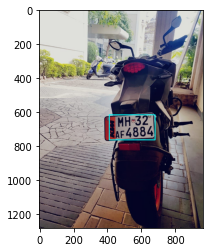

In [54]:
# display the detected rego plate region
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

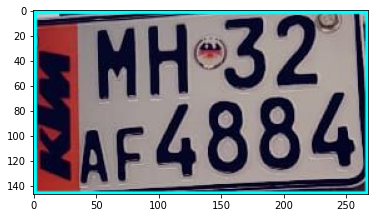

In [55]:
# display the cropped rego plate region

plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))

In [56]:
# convert the cv2 image to bytes array so we can send it over the wire to the API 
crop_bytes =bytes(cv2.imencode('.jpg', img_crop)[1])

In [57]:
# make a call to the text_recognition_url
response = requests.post(
    url=text_recognition_url, 
    data=crop_bytes, 
    headers={'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'})

In [58]:
# Holds the URI used to retrieve the recognized text.
response.raise_for_status()
operation_url = response.headers["Operation-Location"]

In [59]:
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers={'Ocp-Apim-Subscription-Key': subscription_key})
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False

{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 357.44, 'width': 268, 'height': 147, 'unit': 'pixel', 'lines': [{'boundingBox': [45, 10, 235, 2, 238, 65, 48, 74], 'text': 'MH-32', 'words': [{'boundingBox': [46, 12, 233, 5, 235, 65, 51, 75], 'text': 'MH-32', 'confidence': 'Low'}]}, {'boundingBox': [24, 85, 255, 64, 261, 124, 29, 146], 'text': 'AF 4884', 'words': [{'boundingBox': [35, 90, 89, 81, 93, 137, 39, 140], 'text': 'AF'}, {'boundingBox': [99, 80, 254, 66, 256, 126, 102, 136], 'text': '4884'}]}]}]}


In [60]:
for i,l in enumerate(analysis['recognitionResults'][0]['lines']): 
    print(i, ': text found: ', [w['text'] for w in l['words']])

0 : text found:  ['MH-32']
1 : text found:  ['AF', '4884']


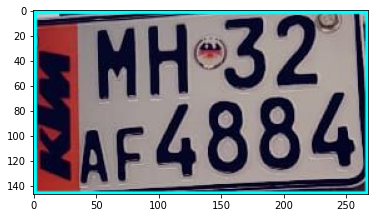

In [61]:
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))